In [53]:
from scipy.special import expit
from rbm import RBM
from sampler import VanillaSampler, PartitionedSampler, ApproximatedSampler, LayerWiseApproxSampler
from trainer import VanillaTrainier
from performance import Result
import numpy as np
import datasets, performance, plotter, mnist, pickle, rbm, os, logging, sampler
from sklearn.linear_model import Perceptron
from sklearn.neural_network import BernoulliRBM

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

logger = logging.getLogger()
# Set the logging level to logging.DEBUG 
logger.setLevel(logging.INFO)


%matplotlib inline


## Helper methods
    
class CountingDict(dict):
    """Cheeky Dictionary useful for counting occurances of reconstructions. """
    def lazy_set(self,key):
        if key not in self:
            self[key] = 1
        else:
            self[key] += 1
            
    def highest_n_items(self, n):
        vals = list(self.values())
        vals.sort()
        return vals[:n]
        

def key_for_visible(v):
    return "v{}".format(v)

def perform(h_a, h_b, v,sampler ,times, num_gibbs=500):
    """Runing times many times and generate visibles based on the supplied hiddens, the number of gibbs sampler per time
        Can also be specified
    """
    result = CountingDict()
    for i in range(times):
        gen_v = sampler.v_to_v(h_a,h_b, v, num_gibbs=num_gibbs)
        key = key_for_visible(gen_v)
        result.lazy_set(key)
             
    return result
    

def goodnight(model, sampler, hours_of_sleep, num_gibbs_per_hour):
    """Generate a dictionary of reconstructions to the number of times they occurred"""
    result_dict = CountingDict()
    v_prime = sampler.dream(model, num_gibbs_per_hour)
    reconstruction_dict = {} # the actual reconstructions that occurred
    for i in range(hours_of_sleep):
        v_prime = sampler.dream(model, num_gibbs_per_hour)
        result_dict.lazy_set(key_for_visible(v_prime))
        reconstruction_dict[key_for_visible(v_prime)] = v_prime
    return result_dict, reconstruction_dict


def build_and_eval(n_hid, n_vis,epochs = 100000, n_reconstructions = 1000, n_gibbs_p_r = 100):
    """Build and evaluate a model for reconising 1 bit on in however many n_vis"""
    model = RBM(n_hid,n_vis,1)
    s = VanillaSampler(model)
    t = VanillaTrainier(model, s)
    t.train(100000, np.eye(n_vis))
    # model.weights
    a,b = goodnight(model, s, n_reconstructions, n_gibbs_p_r)

    plotter.plot_dict(a, title = "Dreams for {} hidden unit model trained with 1 bit on in a pattern of {} many bits".format(n_hid,n_vis))
    return model

def eval_partitioned(model, v, times = 1000, num_gibbs = 400):
    n_hid = model.num_hid()
    h_a = np.random.randint(2,size=(n_hid,))
    h_b = np.random.randint(2,size=(n_hid,))
    s = ApproximatedSampler(model.weights, model.weights,model.hidden_bias, model.hidden_bias)
    d =perform(h_a, h_b, v, s, times, num_gibbs)
    plotter.plot_dict(d, title="v'| {}".format(v), size = "")
    return d

# 3 bits #
In the below cells I explore the next step - three hidden units and three visible units.

The results are very good, for three hiddens and three visibles it works as expected. However it needs a good model to behave itself. Hence I may run ```build_and_eval``` several times until all the expected reconstructions happen almost equally.

In [96]:
# model = build_and_eval(3,3,epochs)
b = BernoulliRBM(n_components=3,n_iter=10000,learning_rate=0.02)
b.fit(np.eye(3))
# b.gibbs(np.array([1,0,0]))
# model.weights


BernoulliRBM(batch_size=10, learning_rate=0.02, n_components=3, n_iter=10000,
       random_state=None, verbose=0)

In [95]:
model.hidden_bias
model.visible_bias
b

BernoulliRBM(batch_size=10, learning_rate=0.02, n_components=3, n_iter=10000,
       random_state=None, verbose=0)

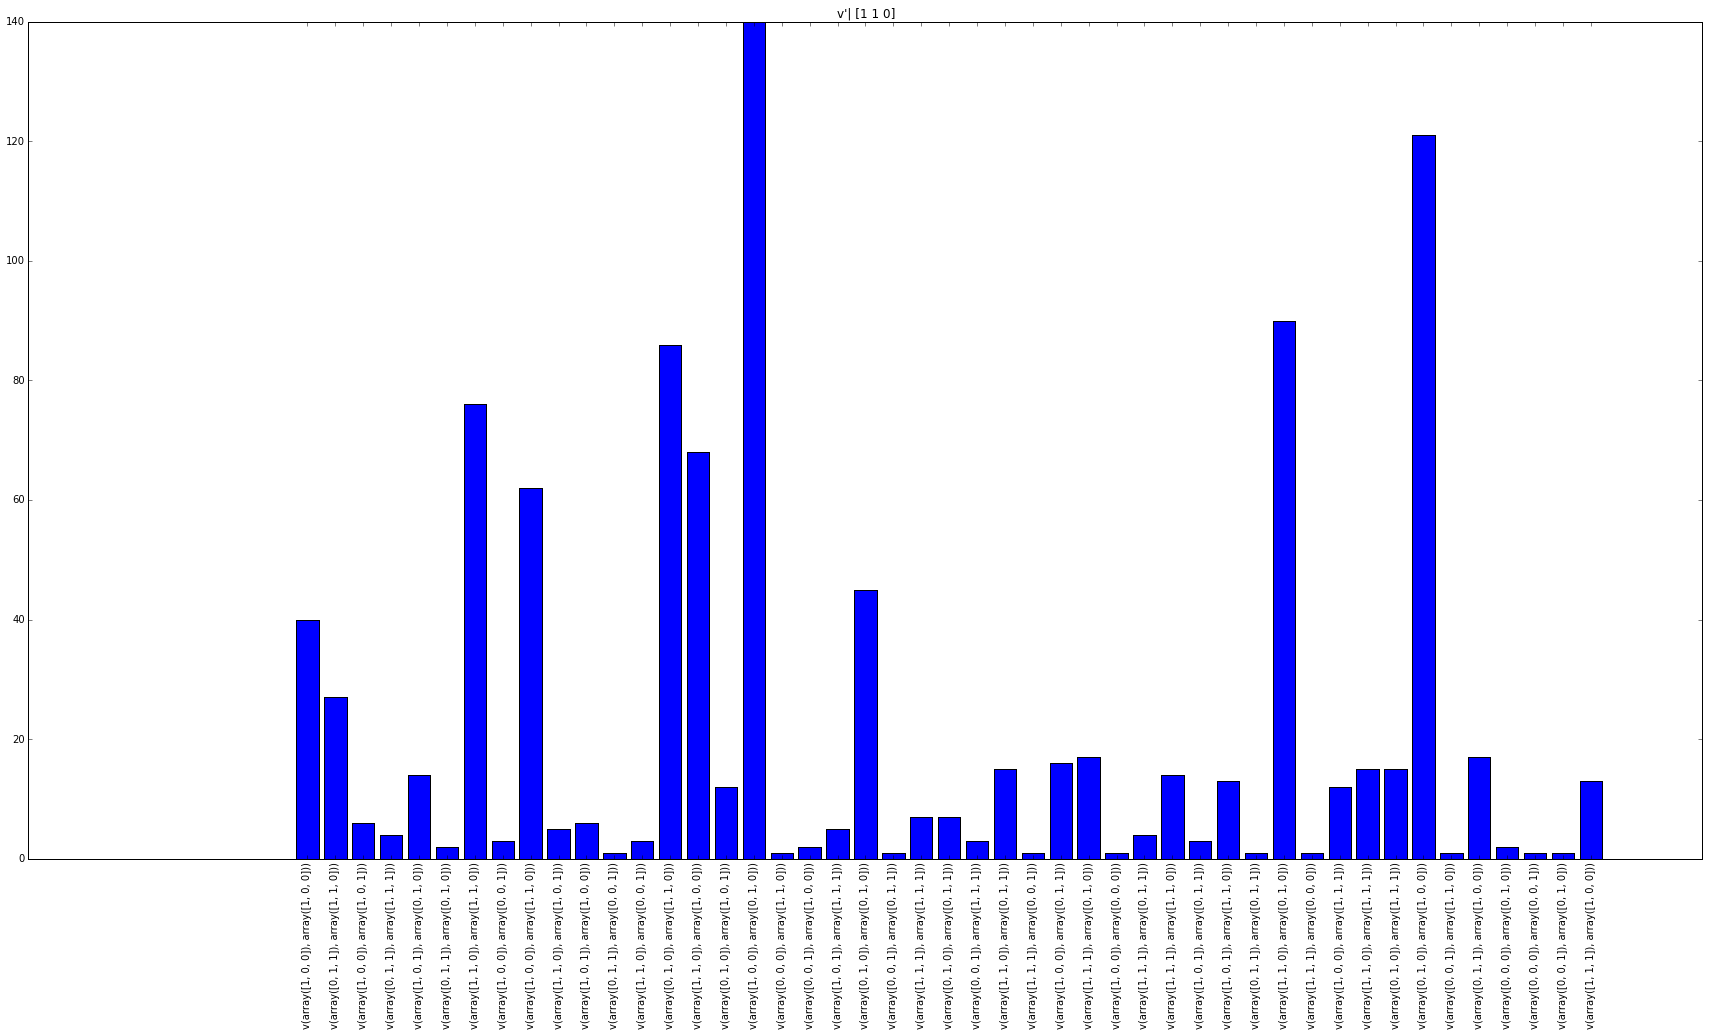

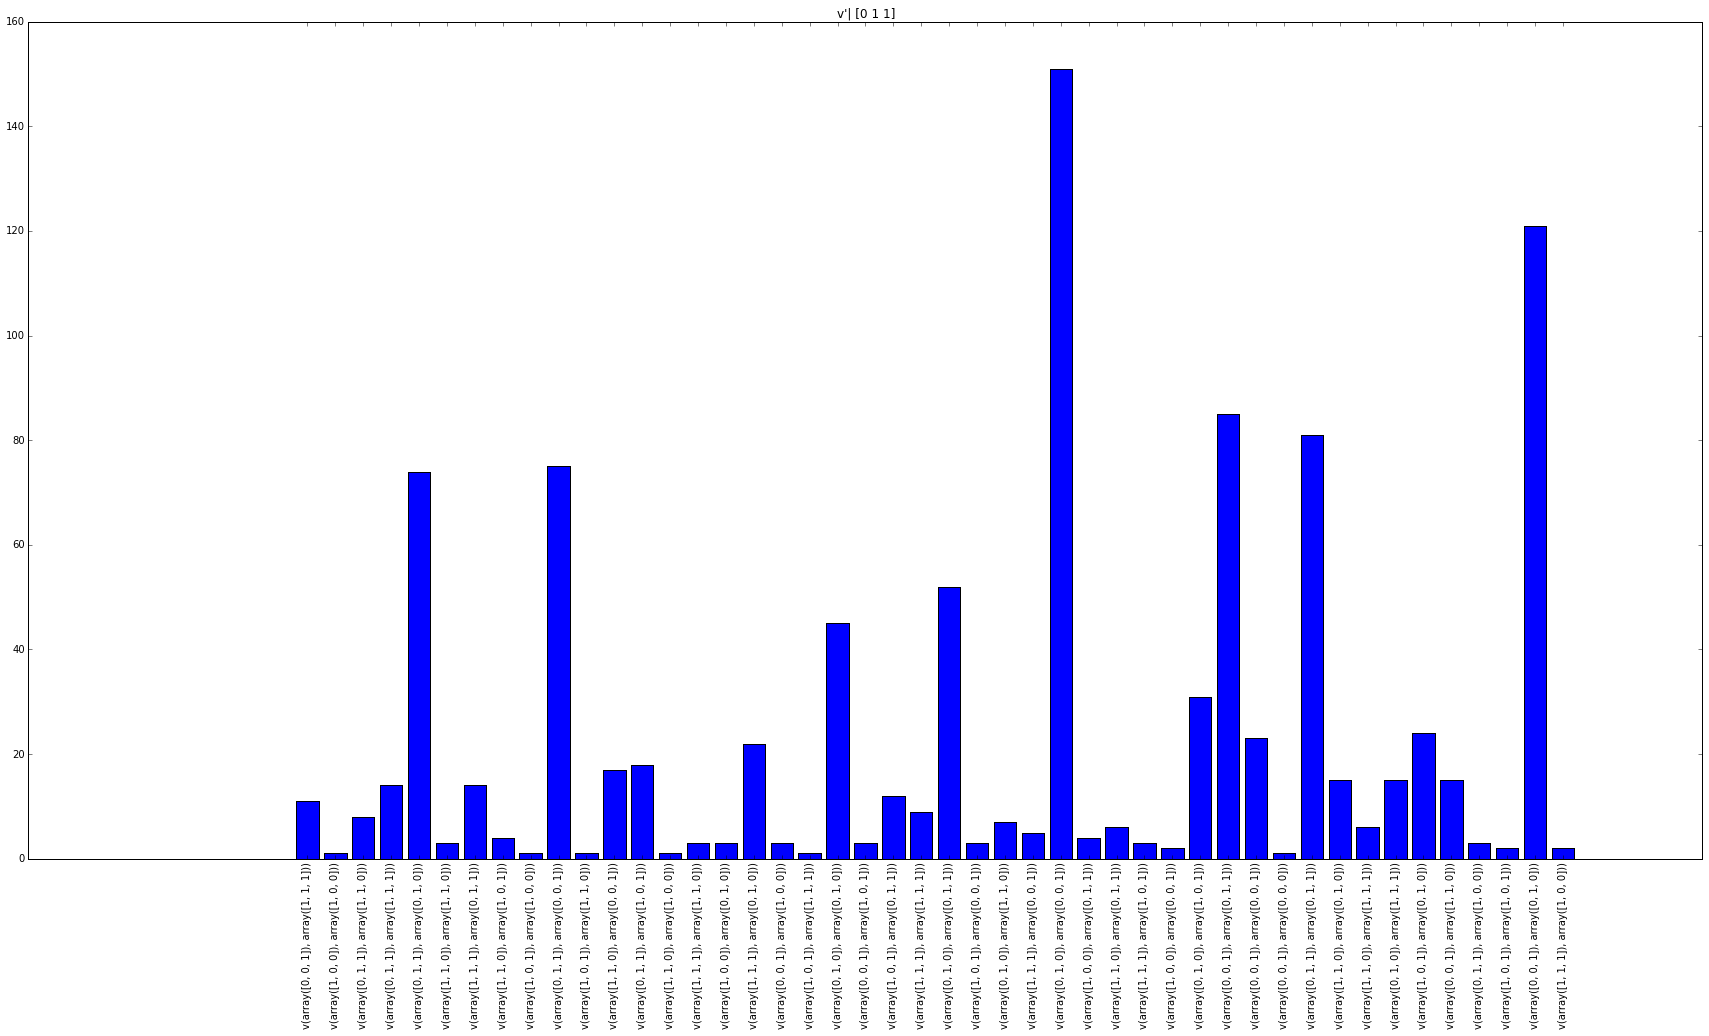

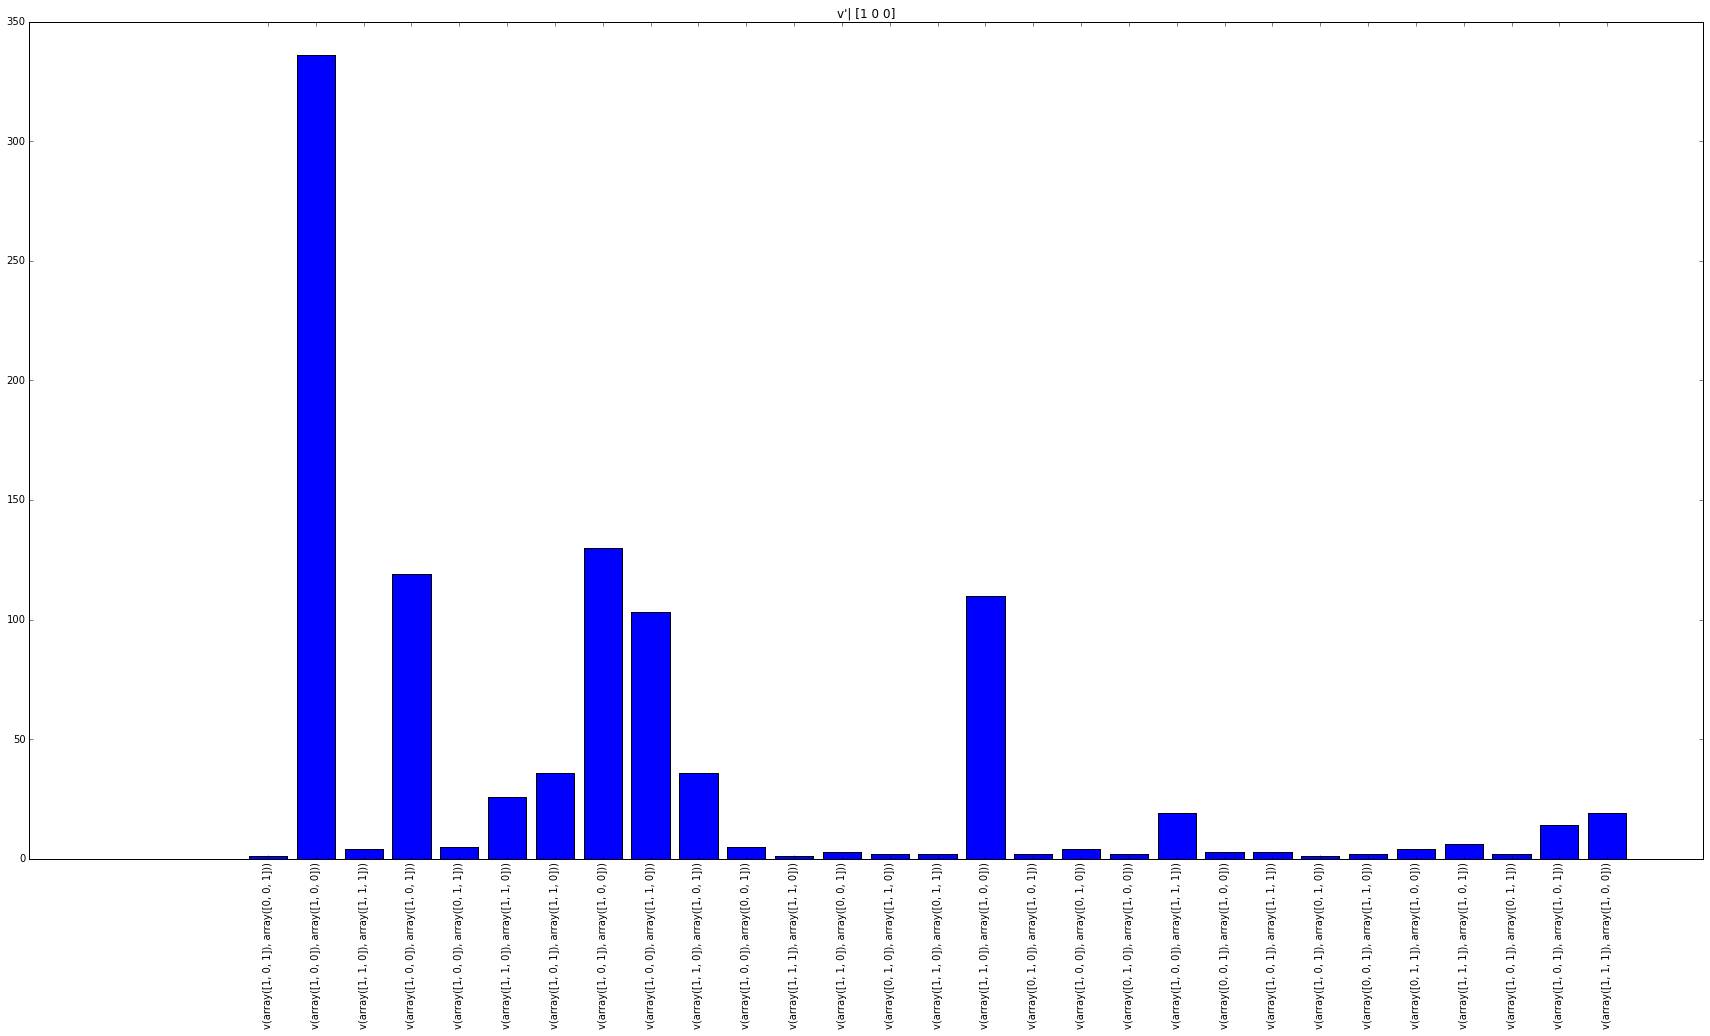

In [57]:
vs = [np.array([1,1,0]),np.array([0,1,1]),np.array([1,0,0])]
for v in vs:
    eval_partitioned(model,v)

# 2 Hiddens, 3 Visible #
I Believe I should be able to create an rbm with this configuration, however all reconstructions have been mixed so far. 

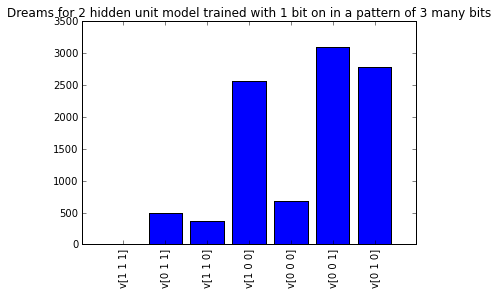

In [76]:
two_bit = build_and_eval(2,3, epochs= 10000, n_reconstructions=10000)

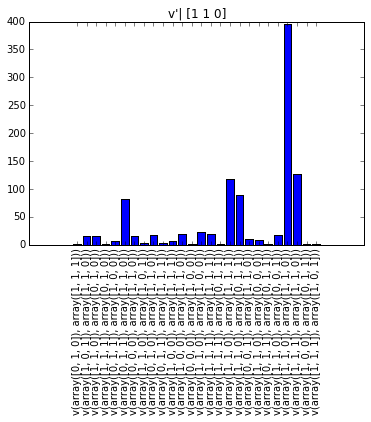

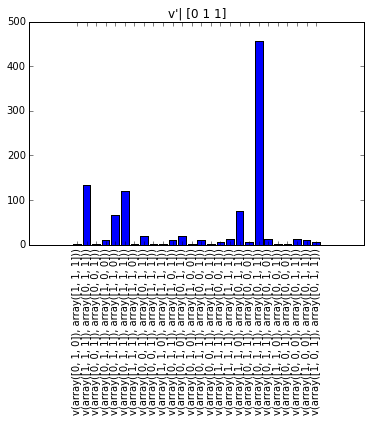

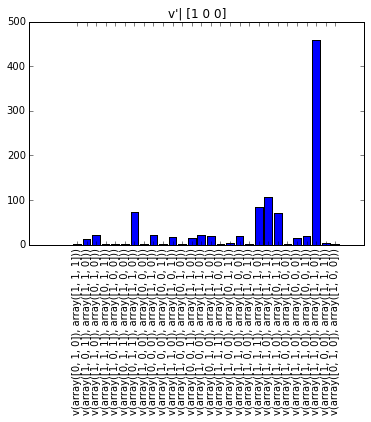

In [77]:
vs = [np.array([1,1,0]),np.array([0,1,1]),np.array([1,0,0])]
for v in vs:
    eval_partitioned(two_bit,v)

# 4 bits # 
Lets try 4 hiddens and 4 visibles
- Excellent it works really well. See graphs below

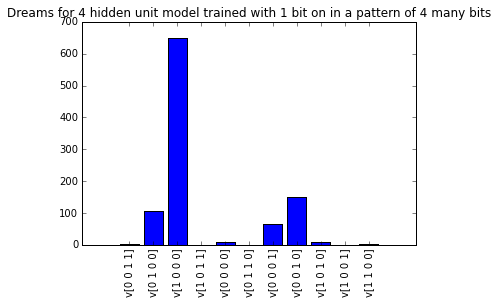

In [58]:
four_bit = build_and_eval(4,4)

In [ ]:
vs = [np.array([1,1,0,0]),np.array([0,1,0,1]),np.array([1,0,0,1])]
for v in vs:
    eval_partitioned(four_bit,v)

#Five Bits#
 
Let's look at whether it is still scaling with 5 bits, (5hid and 5vis)

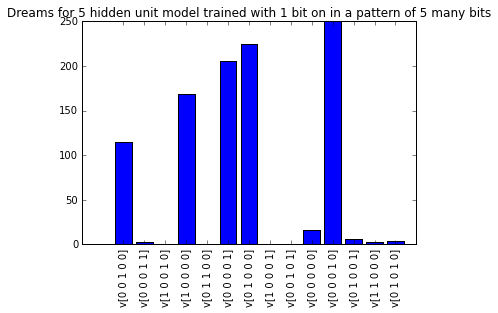

In [33]:
five_bit = build_and_eval(5,5)

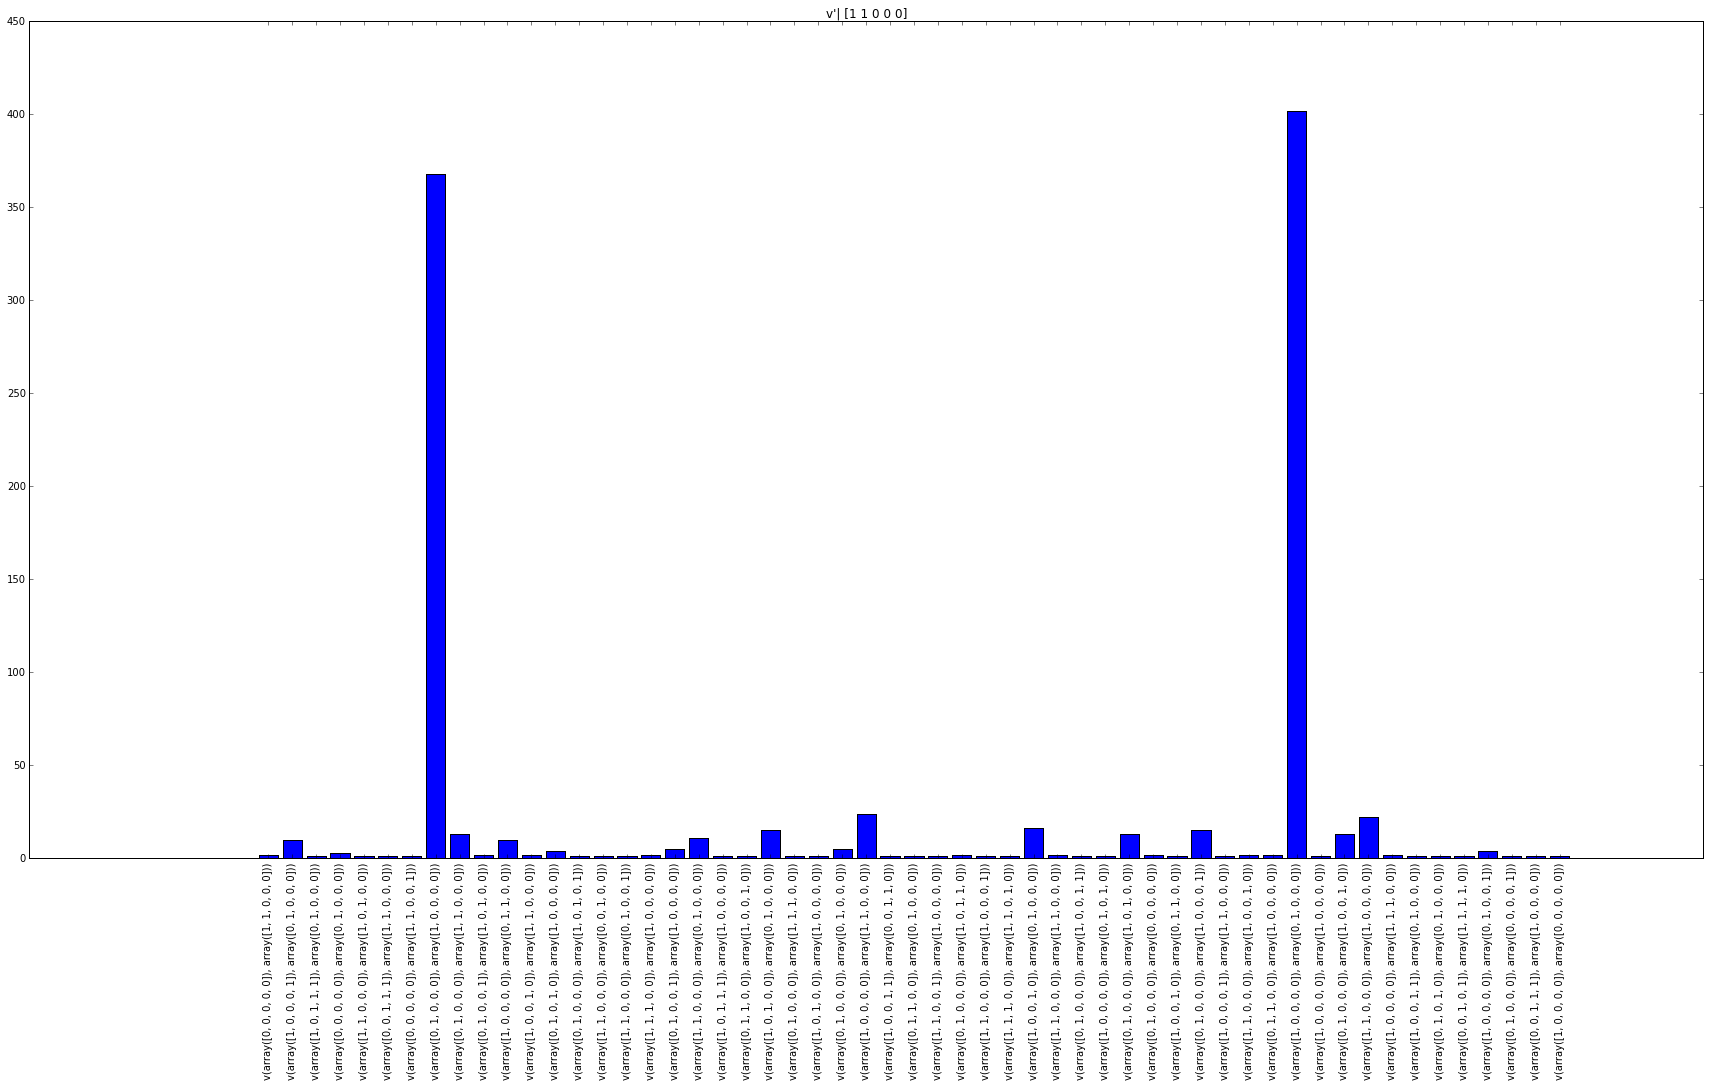

In [34]:
eval_partitioned(five_bit,np.array([1,1,0,0,0]))

#Awesome,#

So it is working up to 5 bits. it just needs a good model - which makes sense. 

# Okay lets try 5 hiddens and 4 visibles #

I would expect this to still perform well, that is separate the causes. the model should be really good, and therefore it should do a great job

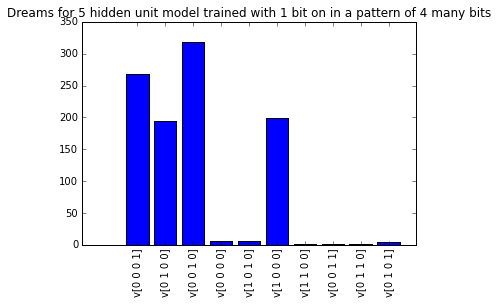

In [12]:
five_hid_four_vis = build_and_eval(5,4)

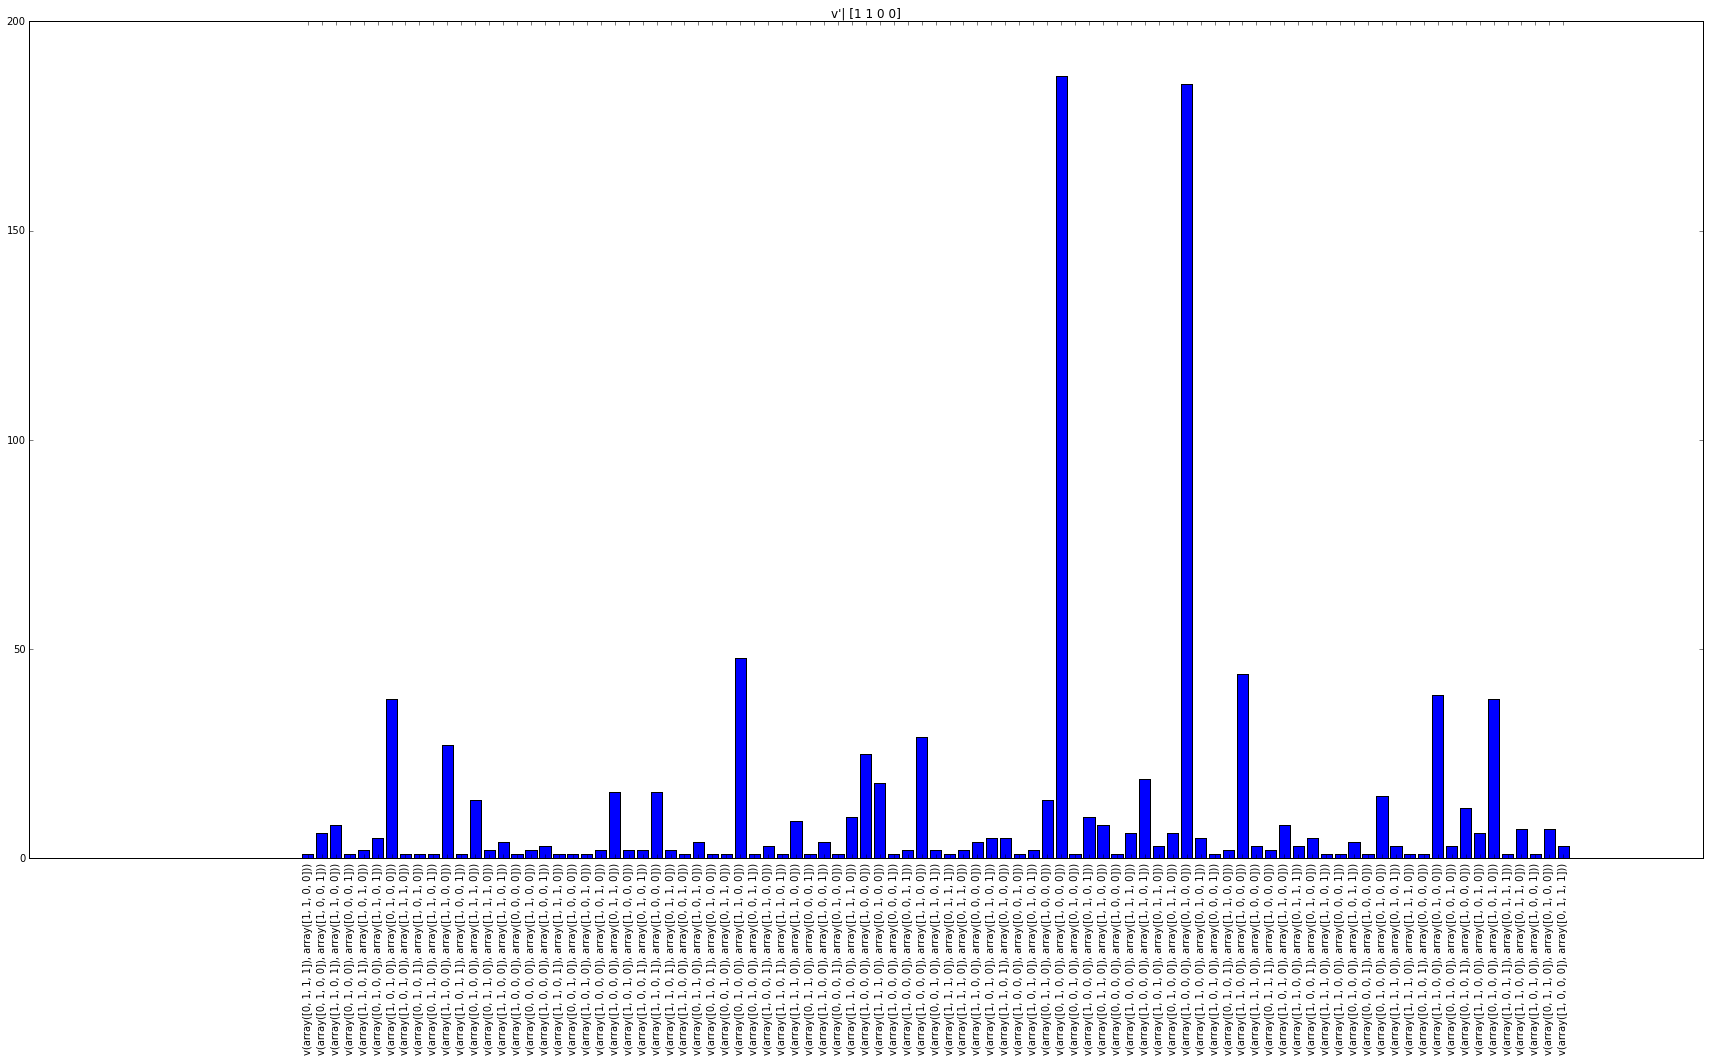

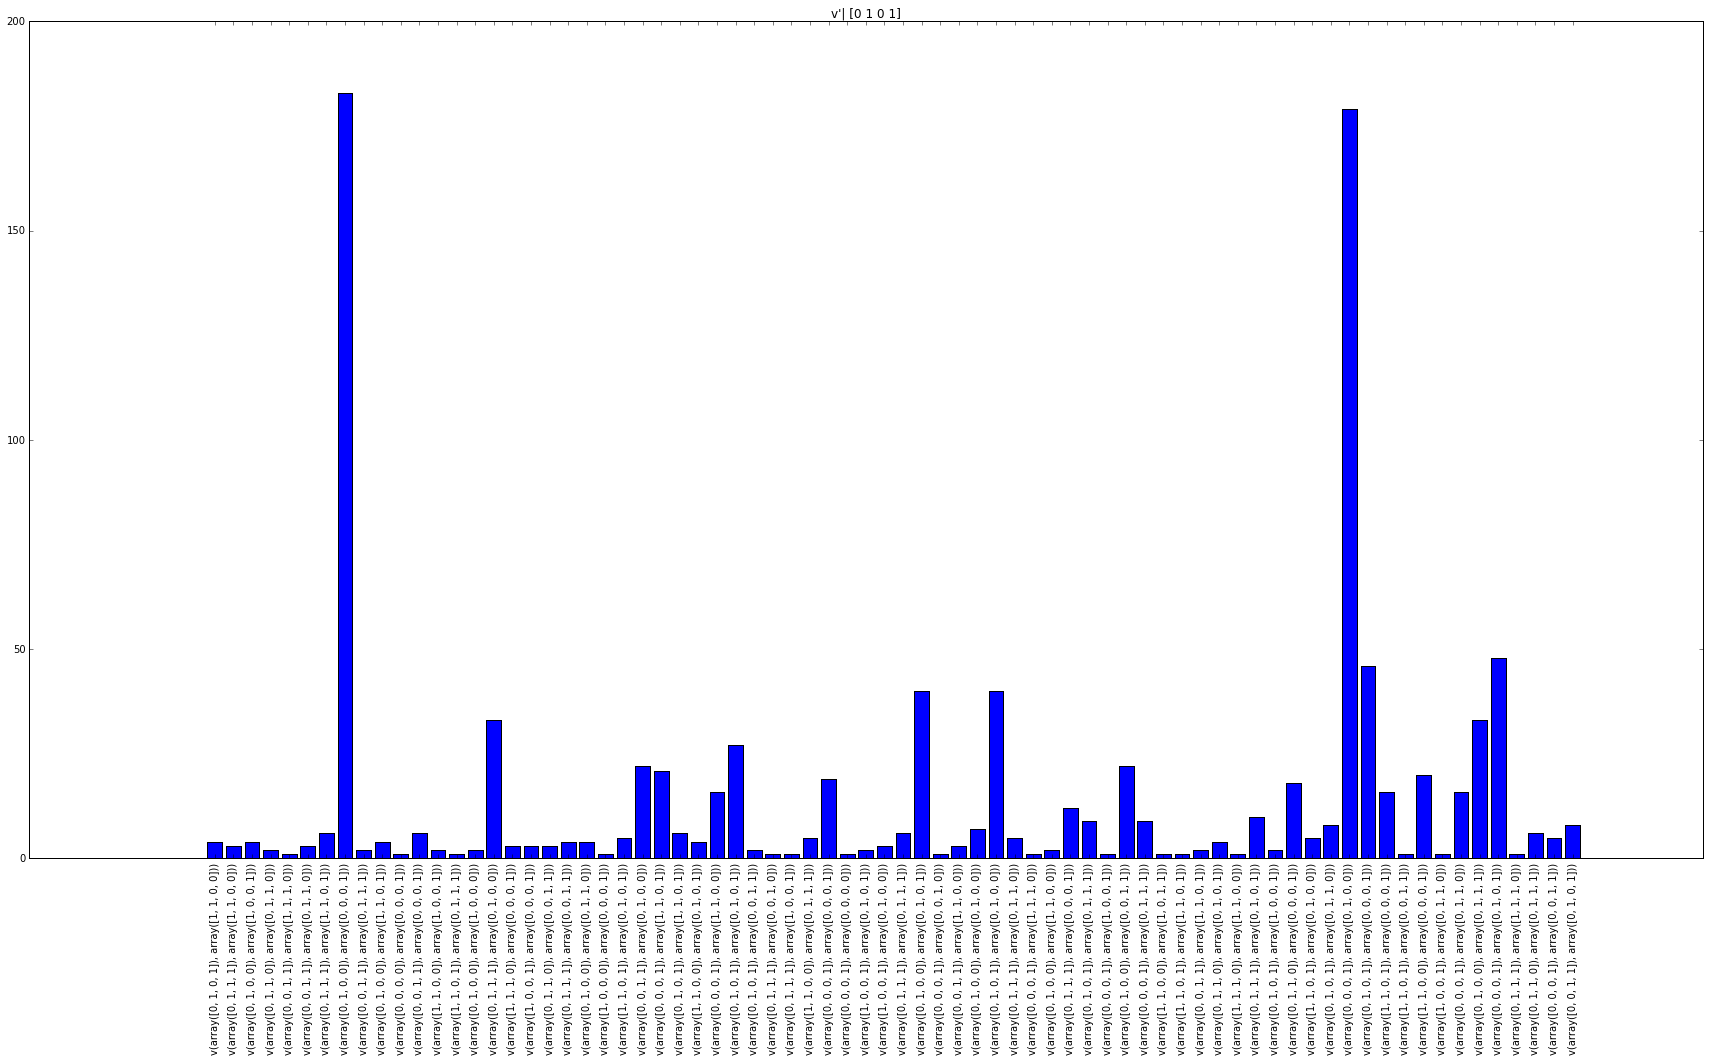

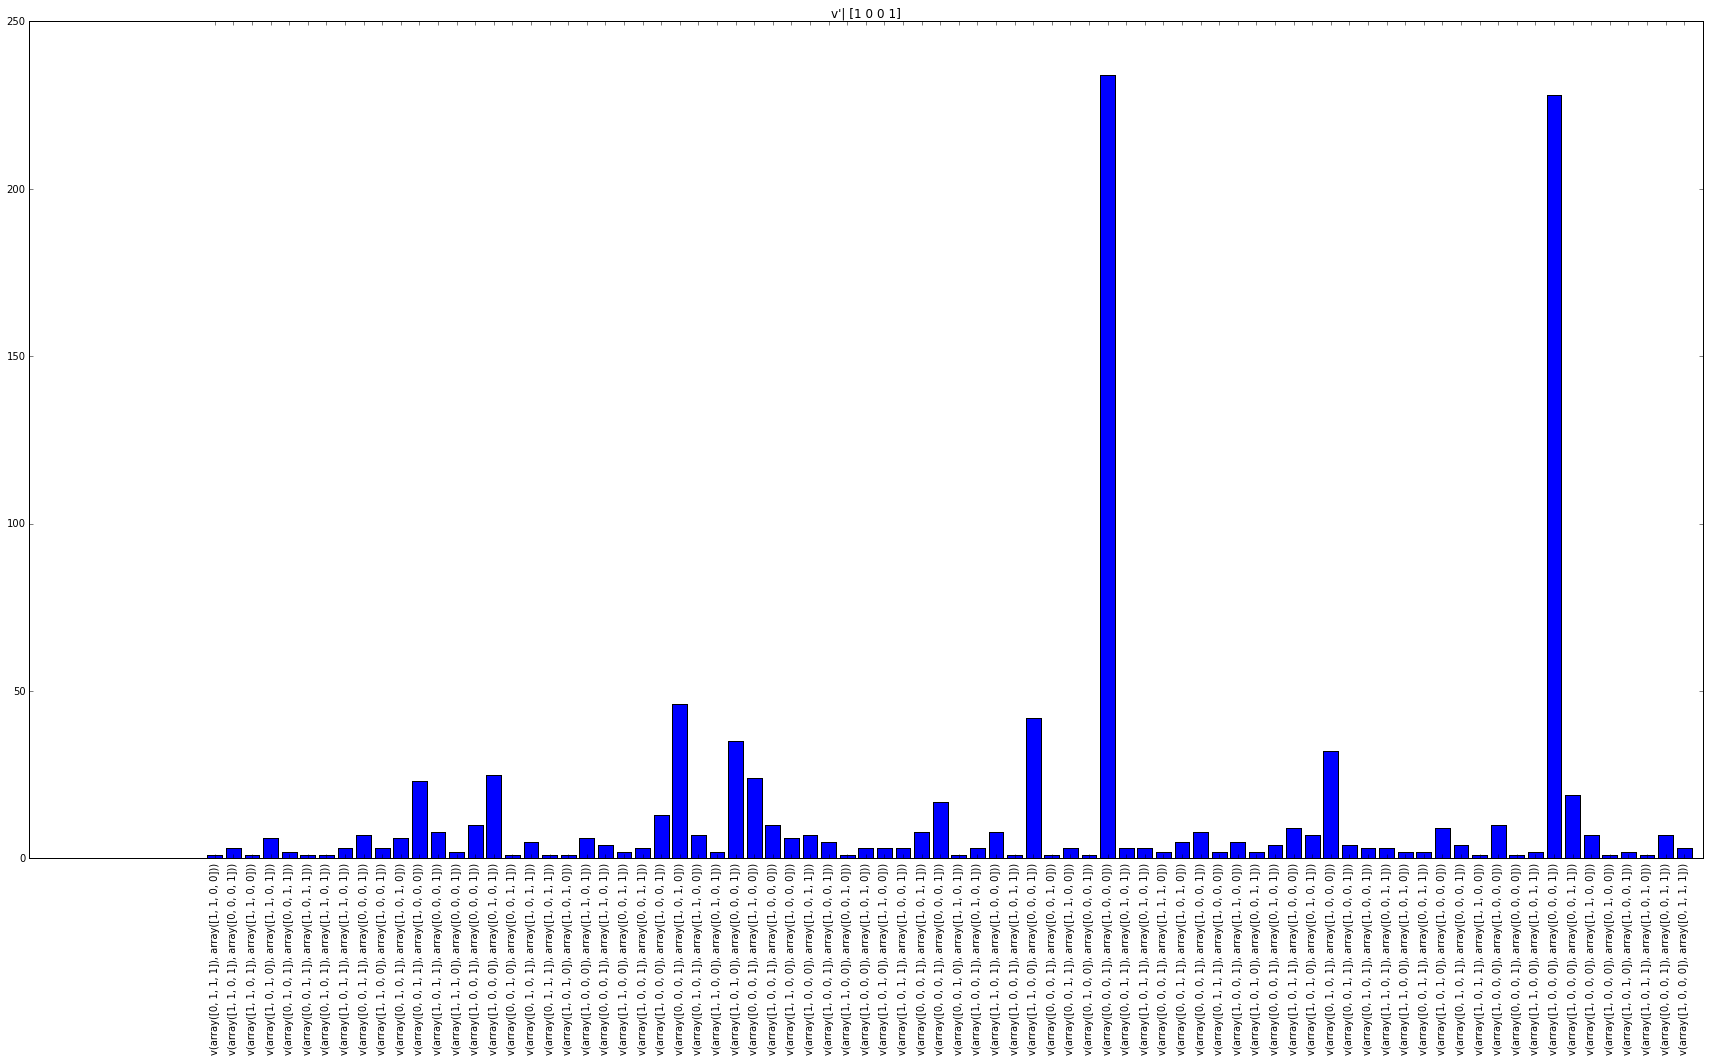

In [13]:
vs = [np.array([1,1,0,0]),np.array([0,1,0,1]),np.array([1,0,0,1])]
for v in vs:
    eval_partitioned(five_hid_four_vis,v)

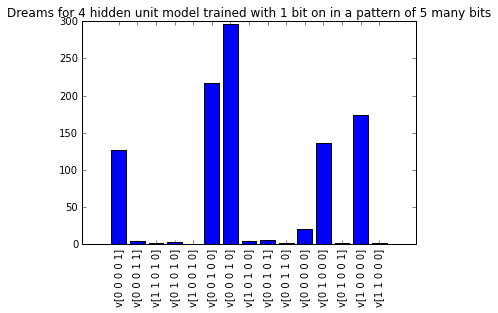

In [40]:
four_hid_five_vis = build_and_eval(4,5)

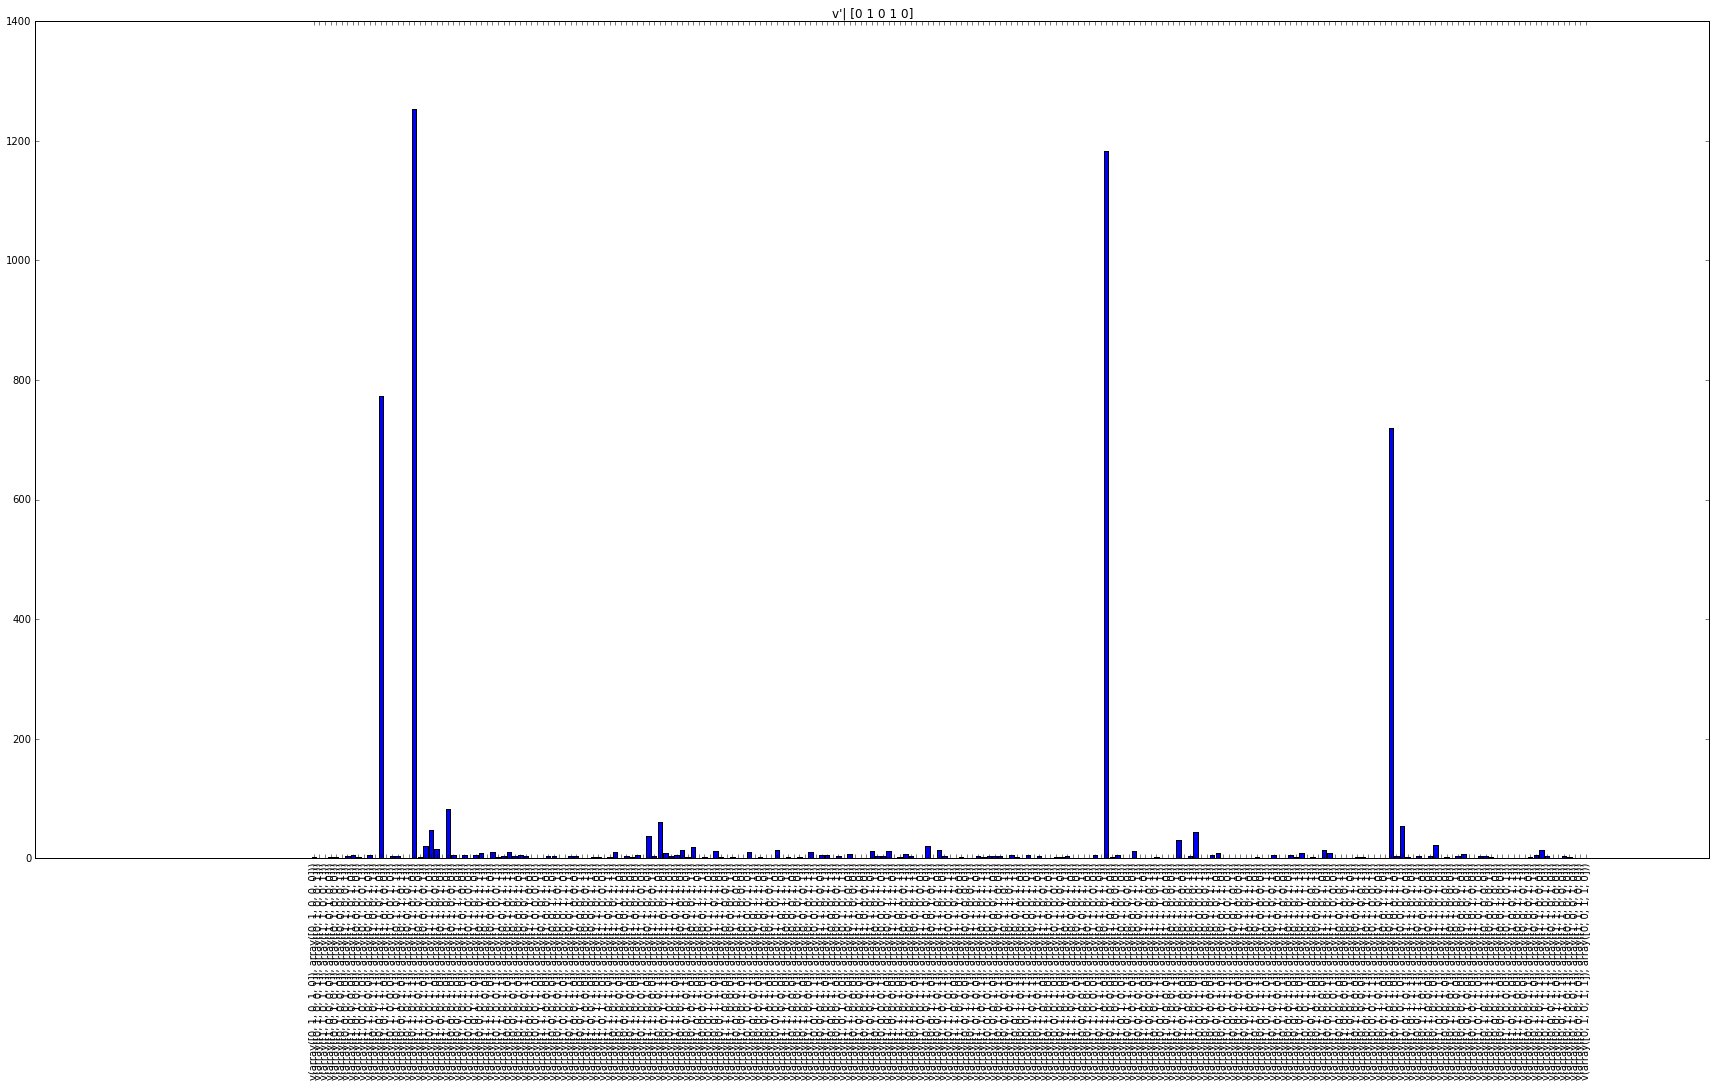

In [54]:
d = eval_partitioned(four_hid_five_vis,np.array([0,1,0,1,0]), times=5000)

In [56]:
d.highest_n_items(3)

[1, 1, 1]

# Lets try and make a really, really good model#

I'm going to do the pathological number of hidden units, that is $2n$ for $n$ visibles. Can I train a perfect (likely super overfit model) and examine the partitioning affect. 



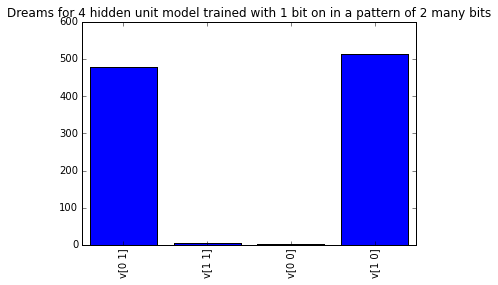

In [11]:
model = build_and_eval(n_hid= 4, n_vis= 2,epochs=1000)

# That is a really strong model #
I would expect 50% of the patterns to be [1,0] and visa versa [0,1]
It took a few tries to get here though

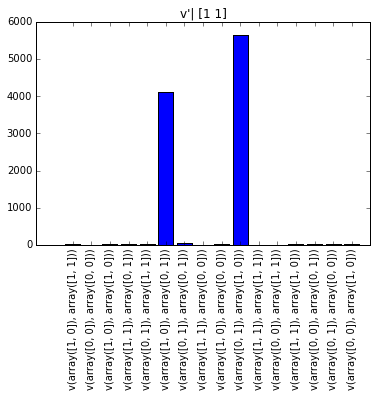

In [17]:
eval_partitioned(model, np.array([1,1]), times=10000)

# Not bad. It separates quite well.

In [2]:
class PlottingSampler(ApproximatedSampler):
    """Wrapper for the sampler allow us to observe the calculation"""
    def approx_correction(self, h_a, h_b, w_a, w_b,v):
        c_a, c_b = super().approx_correction(h_a,h_b,w_a, w_b,v) # wrap those delicious corrections up
#         print("C_A{}\nC_B{}".format(c_a, c_b))
        self.plot_all(self.plot_ready_shape(h_a),self.plot_ready_shape(h_b),c_a,c_b)
        plt.show()
        return c_a, c_b

    def plot_ready_shape(self, h):
        return h.reshape(1,h.shape[0])
    
    def plot_all(self,h_a,h_b,c_a, c_b):
        plt.subplot(141)
        self.plot_hid('h_a',h_a)
        plt.subplot(142)     
        self.plot_hid('h_b',h_b)
        plt.subplot(143)
        self.plot_correction('c_a',self.reshape_for_plot(c_a.sum(1)))
        plt.subplot(144)     
        self.plot_correction('c_b',self.reshape_for_plot(c_b.sum(1)))
        plt.colorbar(ticks=[-1,0,1])
    
    def reshape_for_plot(self, c):
        return c.reshape(1,c.shape[0])
    
    def plot_correction(self,title, c):
        plt.title(title)
        plt.axis('off')
        plt.imshow(c, cmap='seismic', interpolation ='nearest')

    def plot_hid(self,title,h):
        plt.title(title)
        plt.axis('off')
        plt.imshow(h, cmap='copper', interpolation ='nearest')
    


# Updating the Hidden States Layerwise V Alternatives #

So we know that we should possibly (but hopefully not) actually let a given update to the hiddens mutilple times, because the $h^A$ and $h^A$ are depedant on each other. Actaully each unit of each hidden layer is depedant on each other. So the full version would be to update a given $h^A_j$ for all $j$ and do the same for $h^B_k $ - Realistically do this I would probably swap to a Java implementation, two reasons:
- Efficiency, for $1,..,n $ hidden units I would have $n$ iterations for each $j$ plus the eqiuvalent $k$ for the the other layer.. :(
- Indices, personally a lot easier to keep track of in Java. Would want typechecking and explicit for loops.

Hopefully it won't come to that, hence what i'm doing below

Up until this point I update the hidden states (for both layers) all at once. I calculate $h^A$ and $h^B$ all at once given a $v$. But it's worth looking into how this affects the reconstructions. So I will compare the current technique to:
- Update $h^A | v$ to get $h'^A$, where the correction is calculated using $h^B$
- Update $h^B | v$ to get $h'^B$, where the correction is now calculated using $h'^A$
- Update $h^A | v$ to get $h'^A$, where the correction is calculated using $h'^A$
- Finally do an update given $h'^A$ and $h'^A$

Or in words: Update the left layer, then update the right based on the update to the left. Then update the left based on the new right and the current left. And then update both the left and right based on these values. Hopefully this won't perform drasitcally better, especially because I am only Markov Chaining(?Is this what I am doing?)

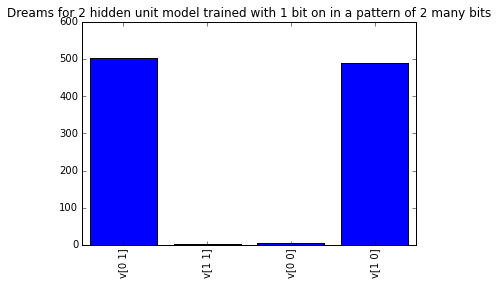

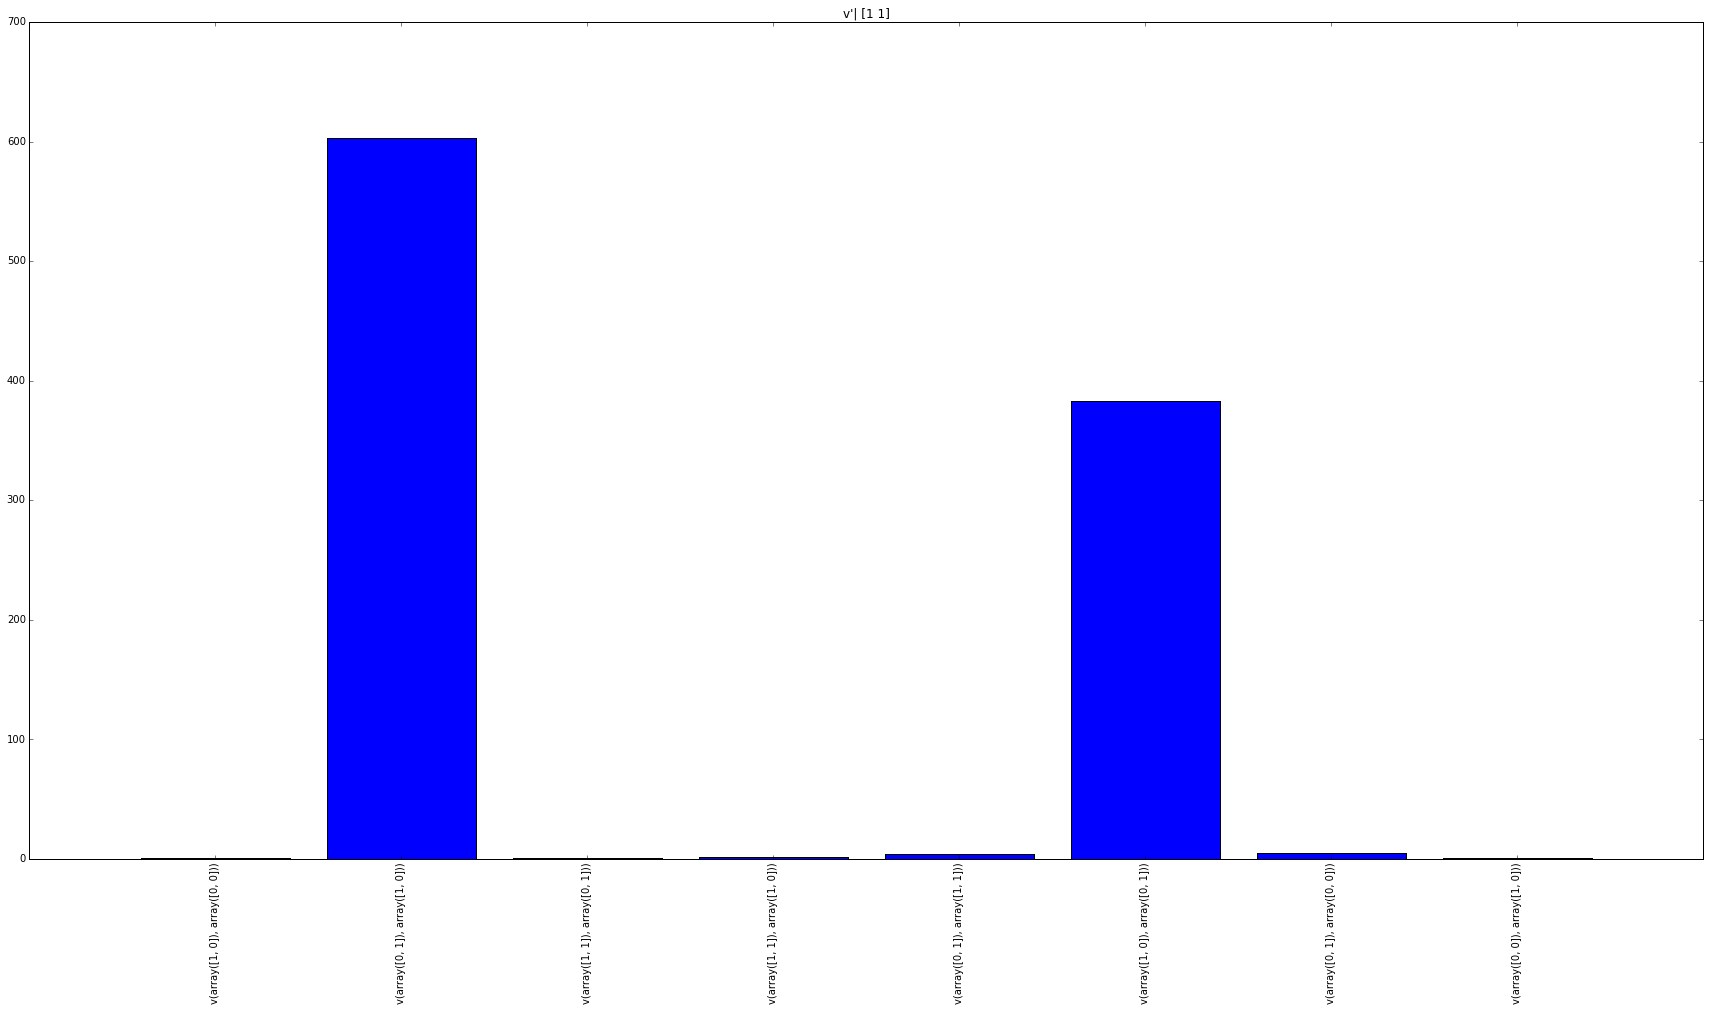

In [4]:
## Separation with 2 hids and 2 vis
model = build_and_eval(2,2)
n_hid = model.num_hid()
h_a = np.random.randint(2,size=(n_hid,))
h_b = np.random.randint(2,size=(n_hid,))
v=np.array([1,1])
s = ApproximatedSampler(model.weights, model.weights,model.hidden_bias, model.hidden_bias)
plotter.plot_dict(perform(h_a, h_b, v, s, 1000, 400), title="v'| {}".format(v), size = "")

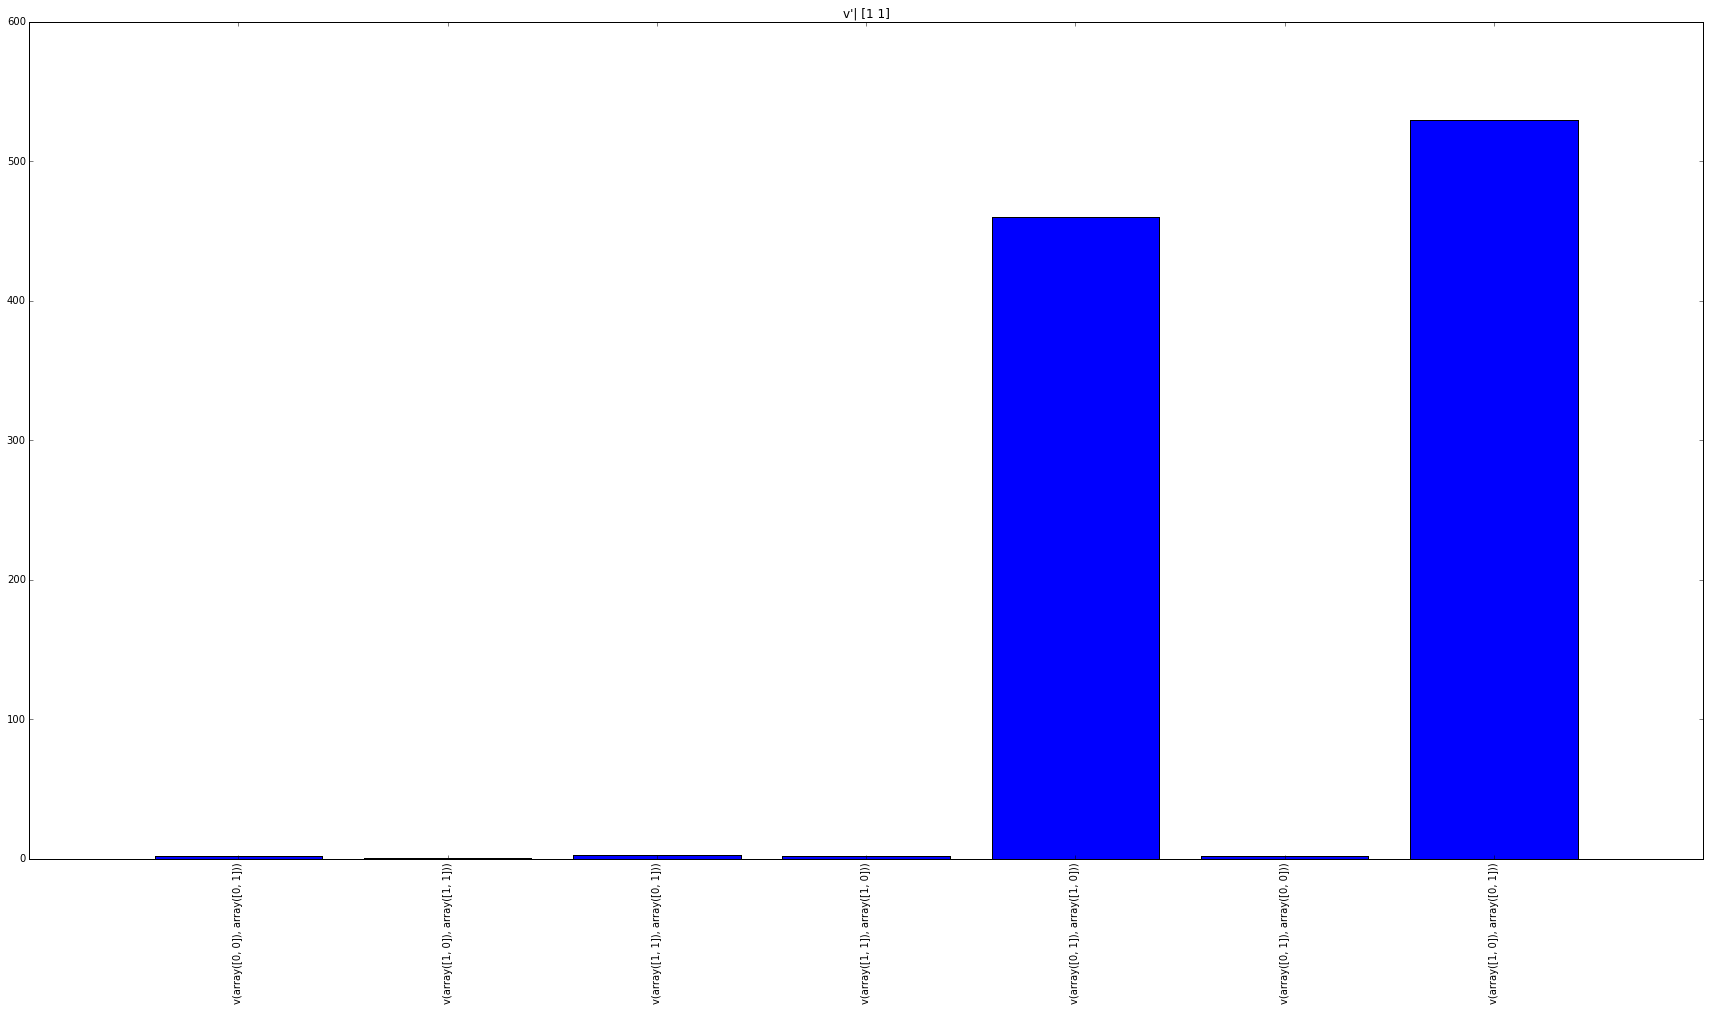

In [5]:
# Compare that to the separation of the layerwise h_a updater
s = LayerWiseApproxSampler(model.weights, model.weights,model.hidden_bias, model.hidden_bias)
plotter.plot_dict(perform(h_a, h_b, v, s, 1000, 400), title="v'| {}".format(v), size = "")

#hmmmm roughly the same - Good #

So now lets try with a worse model, does the new approach account for a weaker model. I don't think it will, but it's worth seeing.

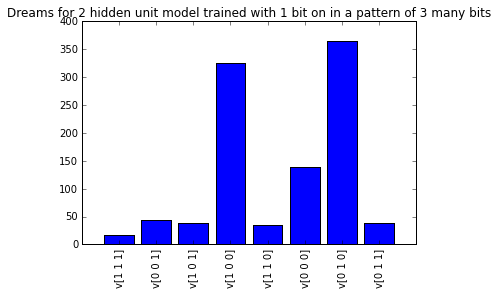

In [23]:
# Two hiddens
model = build_and_eval(2,3)

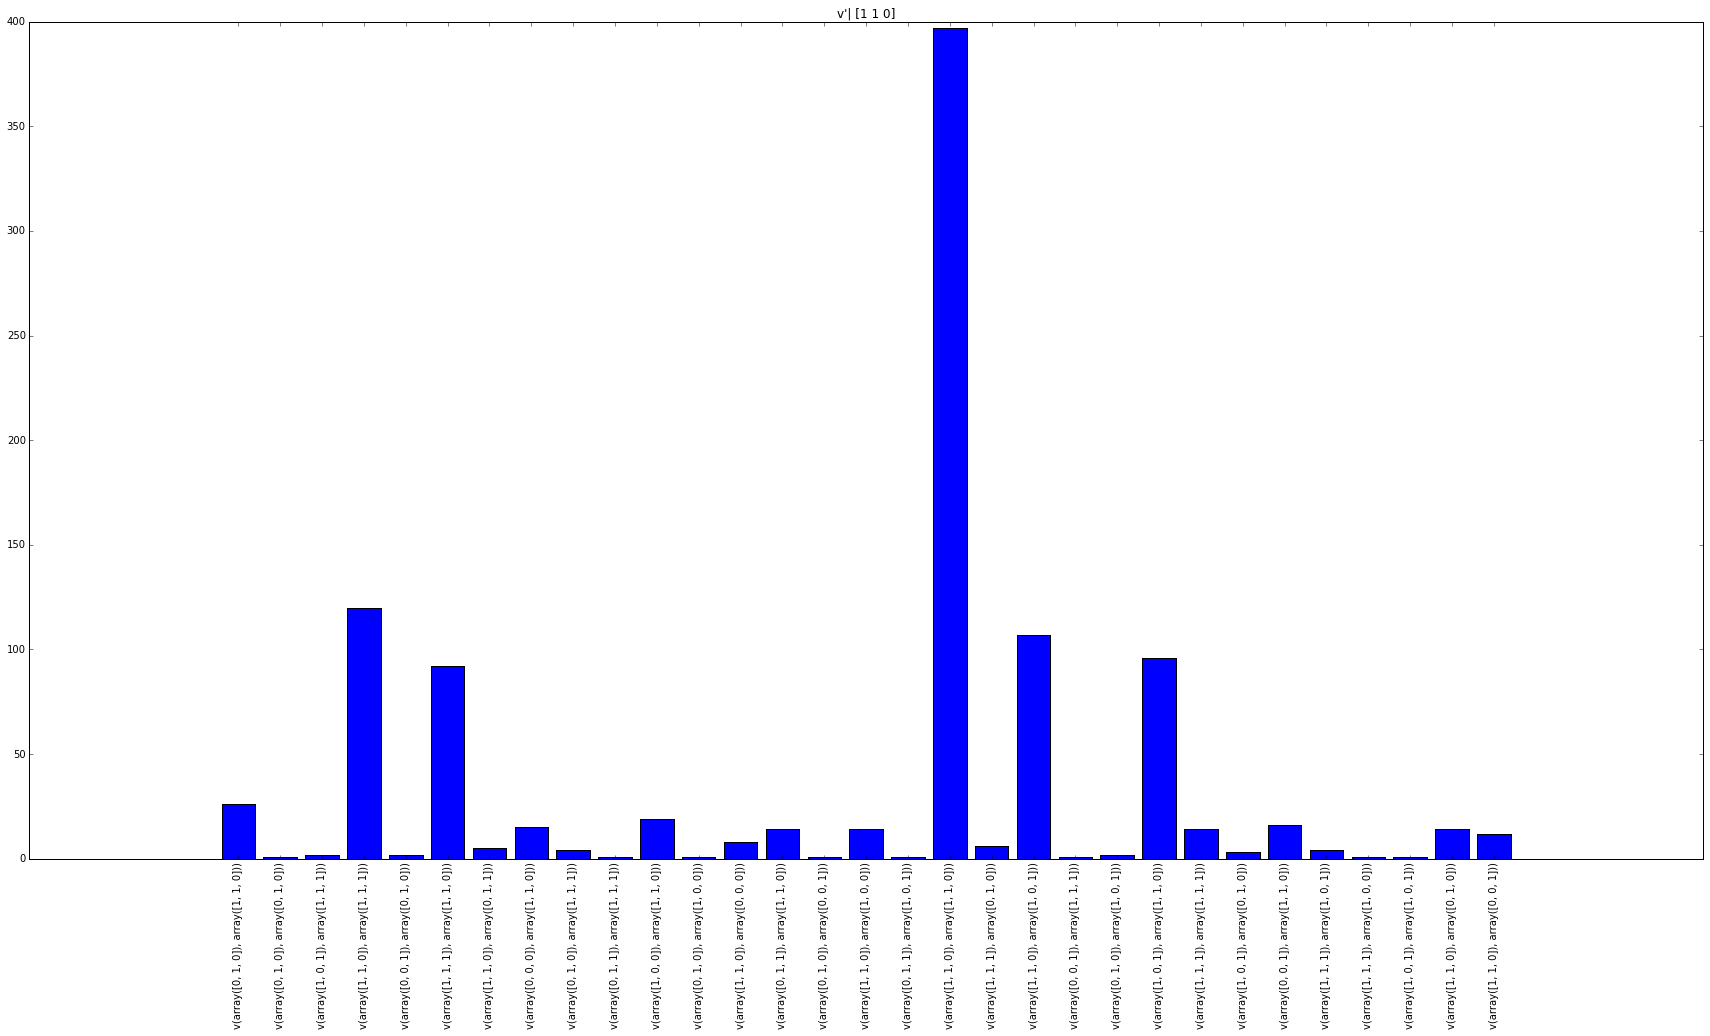

In [18]:
n_hid = model.num_hid()
h_a = np.random.randint(2,size=(n_hid,))
h_b = np.random.randint(2,size=(n_hid,))
v=np.array([1,1,0])
s = LayerWiseApproxSampler(model.weights, model.weights,model.hidden_bias, model.hidden_bias)
plotter.plot_dict(perform(h_a, h_b, v, s, 1000, 1000), title="v'| {}".format(v), size = "")

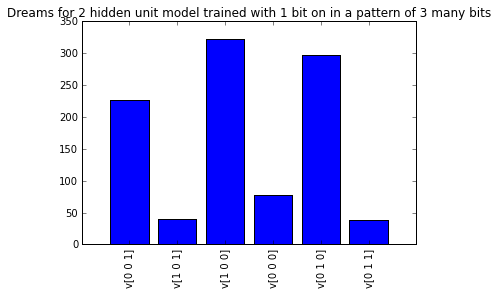

In [40]:
model = build_and_eval(2,3, epochs= 20000,n_gibbs_p_r= 400 )

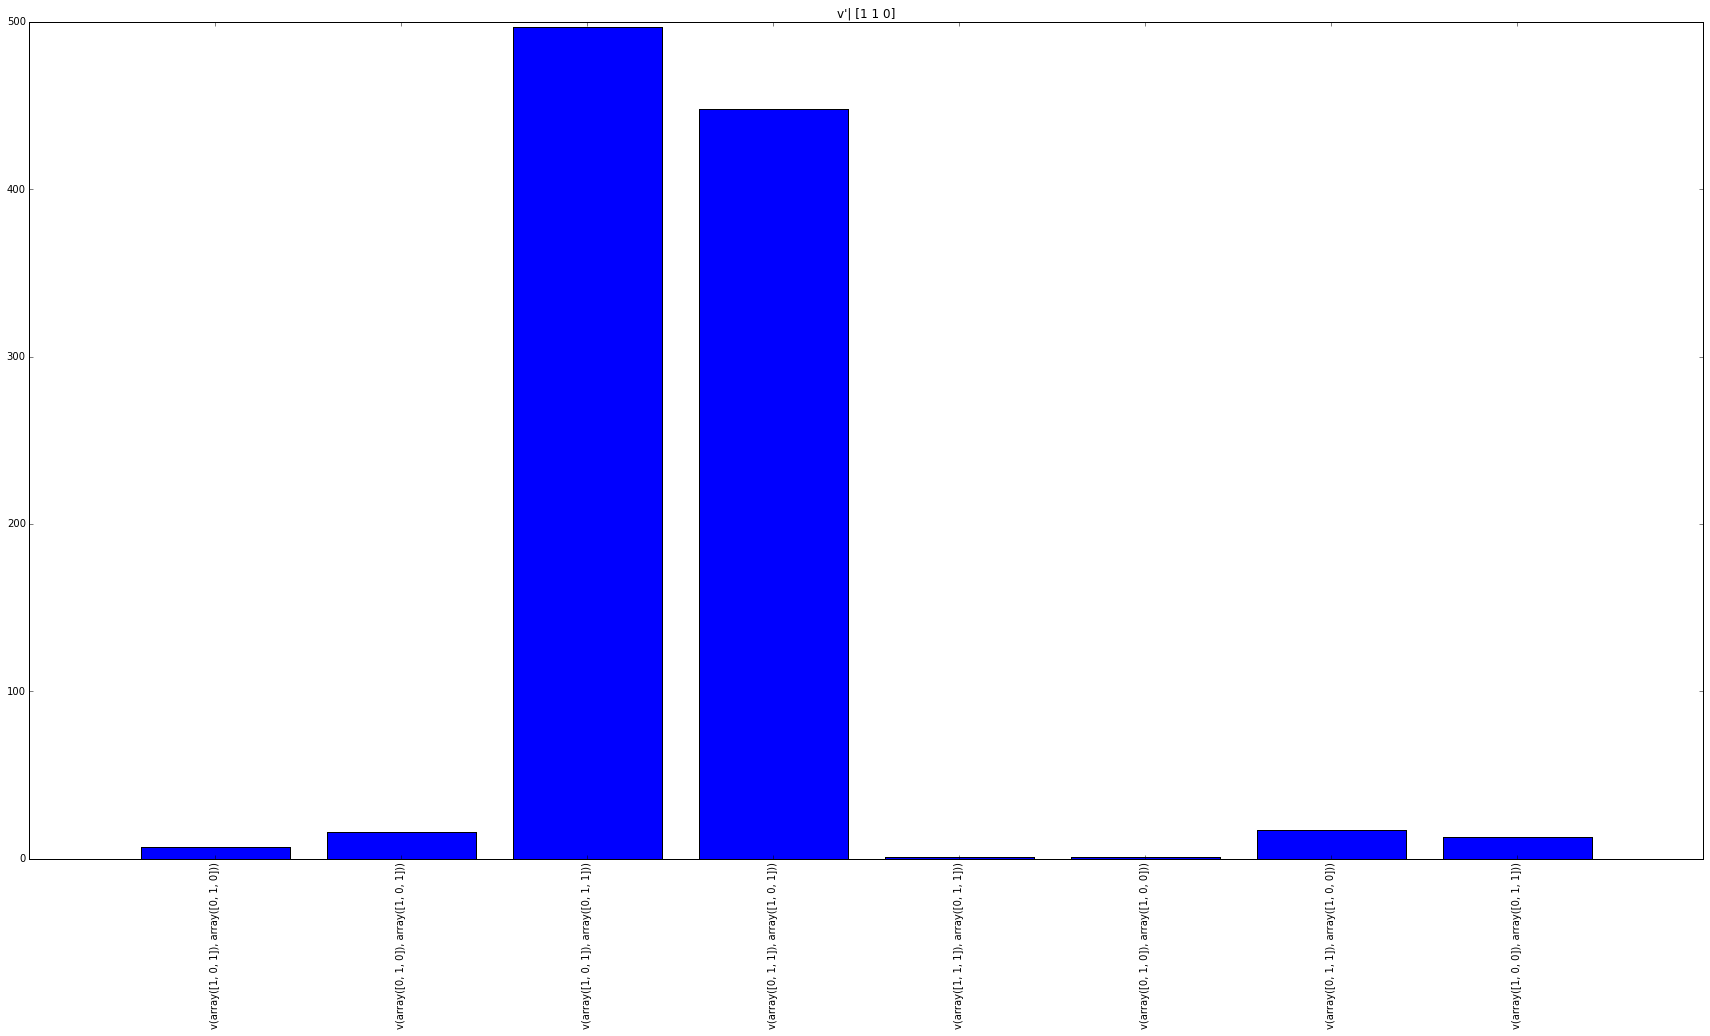

In [41]:
n_hid = model.num_hid()
h_a = np.random.randint(2,size=(n_hid,))
h_b = np.random.randint(2,size=(n_hid,))
v=np.array([1,1,0])
s = LayerWiseApproxSampler(model.weights, model.weights,model.hidden_bias, model.hidden_bias)
plotter.plot_dict(perform(h_a, h_b, v, s, 1000, 1000), title="v'| {}".format(v), size = "")

# So it doesn't help with a worse Model, ah well #